# NLP EDA

Basically, exploration and modeling boil down to a single question:

How do we quantify our data/text

In this lesson, we'll explore answers to this question that will aid in visualization.

- word frequency (by label)
- ngrams
- word cloud
- sentiment analysis
- other common features

## Setup

Data is spam/ham text messages.

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nltk
import unicodedata
import re

In [3]:
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-darkgrid')

In [4]:
def clean(text):
    '''Simplified text cleaning function'''
    text = text.lower()
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return re.sub(r"[^a-z0-9\s]", '', text)

In [5]:
#acquire data from spam_db

# from env import user, password, host

# def get_db_url(database, host=host, user=user, password=password):
#     return f'mysql+pymysql://{user}:{password}@{host}/{database}'


# url = get_db_url("spam_db")
# sql = "SELECT * FROM spam"

# df = pd.read_sql(sql, url, index_col="id")
# df.head()

Permissions error for db pull, ravinder is uploading a csv


In [6]:
df = pd.read_csv('spam_clean.csv')

In [7]:
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
# View full column text
pd.set_option('display.max_colwidth', -1)


/var/folders/9y/17ptyrds267724n2_7s7hx340000gn/T/ipykernel_2039/1227635164.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [9]:
# how many spam and ham observations do we have?

df.label.value_counts(normalize = True)

ham     0.865937
spam    0.134063
Name: label, dtype: float64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [11]:
# combine all messages in single string by label

ham_words = clean(' '.join(df[df.label == 'ham'].text))
spam_words = clean(' '.join(df[df.label == 'spam'].text))
all_words = clean(' '.join(df.text))

## Exploration

Represent text as word frequencies.

In [12]:
ham_freq = pd.Series(ham_words.split()).value_counts()
spam_freq = pd.Series(spam_words.split()).value_counts()
all_freq = pd.Series(all_words.split()).value_counts()

In [13]:
ham_freq

i                  2305
you                1837
to                 1554
the                1118
a                  1055
                   ... 
oath               1   
tactless           1   
astoundingly       1   
acknowledgement    1   
bitching           1   
Length: 7555, dtype: int64

In [14]:
# concat all frequencies together into a dataframe

word_counts = pd.concat([ham_freq, spam_freq, all_freq], axis=1).fillna(0).astype(int)
word_counts.columns = ['ham', 'spam', 'all']
word_counts.head()

,ham,spam,all
i,2305,45,2350
you,1837,287,2124
to,1554,686,2240
the,1118,204,1322
a,1055,376,1431


- What are the most frequently occuring words?
- Are there any words that uniquely identify a spam or ham message? I.e. words present in one type of message but not the other?

In [15]:
# sort by 'all'

word_counts.sort_values('all', ascending=False).head(20)

,ham,spam,all
i,2305,45,2350
to,1554,686,2240
you,1837,287,2124
a,1055,376,1431
the,1118,204,1322
u,986,147,1133
and,848,122,970
is,728,158,886
in,811,73,884
me,756,30,786


Looks like all stopwords - should remove

In [16]:
# sort by 'ham' and 'spam' columns
word_counts.sort_values(['ham', 'spam'], ascending=[True, False]).head(20)

,ham,spam,all
claim,0,113,113
prize,0,92,92
won,0,73,73
guaranteed,0,50,50
tone,0,48,48
18,0,43,43
awarded,0,38,38
a1000,0,35,35
150ppm,0,34,34
a2000,0,31,31


### Visualization

- ham vs spam count for 20 most common words
- ham vs spam proportion for 20 most common words

Text(0.5, 1.0, 'Ham vs Spam count for the top 20 most frequent words')

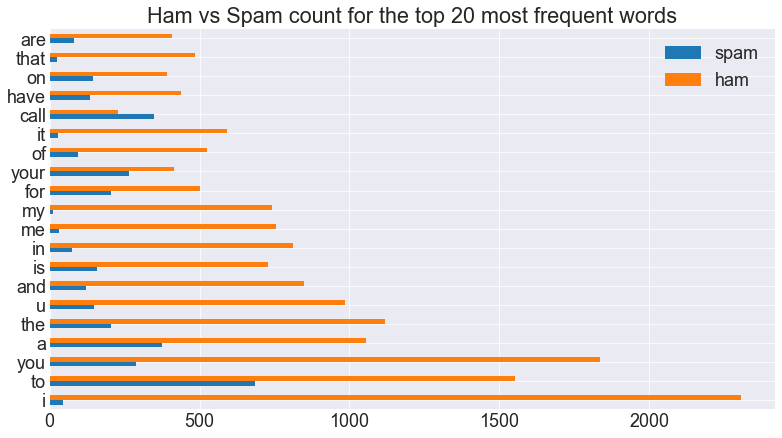

In [17]:
plt.rc('font', size=18)
word_counts.sort_values('all', ascending=False).head(20)[['spam', 'ham']].plot.barh()
plt.title('Ham vs Spam count for the top 20 most frequent words')

Text(0.5, 1.0, '% of spam vs ham for the most common 20 words')

<Figure size 1152x648 with 0 Axes>

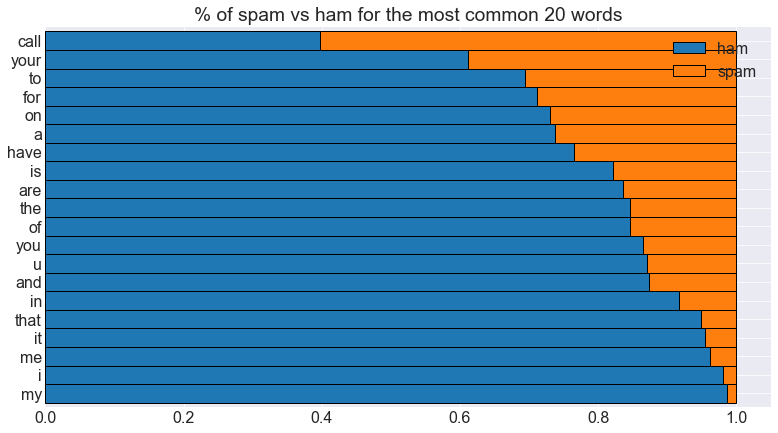

In [18]:
plt.figure(figsize=(16, 9))
plt.rc('font', size=16)

(word_counts.sort_values('all', ascending=False)
 .head(20)
 .apply(lambda row: row/row['all'], axis = 1)
 .drop(columns = 'all')
 .sort_values(by = 'spam')
 .plot.barh(stacked = True, width = 1, ec = 'k')
)
plt.title('% of spam vs ham for the most common 20 words')

Values still are not normalized to the relative frequency of 'ham' and 'spam' messages. Need to account for imbalances in copus sizes (85/15 split)

## n-grams

**bigram**: combinations of 2 words

Represent text as combinations of 2 words

In [19]:
sentence = 'Today is tuesday, and the weather is nice.'

In [20]:
list(nltk.bigrams(sentence.split()))

[('Today', 'is'),
 ('is', 'tuesday,'),
 ('tuesday,', 'and'),
 ('and', 'the'),
 ('the', 'weather'),
 ('weather', 'is'),
 ('is', 'nice.')]

**Be Careful!** Make sure you are making bigrams out of *words*.

In [21]:
# Don't do this!
#list(nltk.bigrams(sentence))

- what are the most common bigrams? spam bigrams? ham bigrams?
- visualize 20 most common bigrams, most common ham bigrams
- ngrams

Find the most common bigram and then find a representative text

Text(0.5, 1.0, 'Top 10 most common spam bigrams')

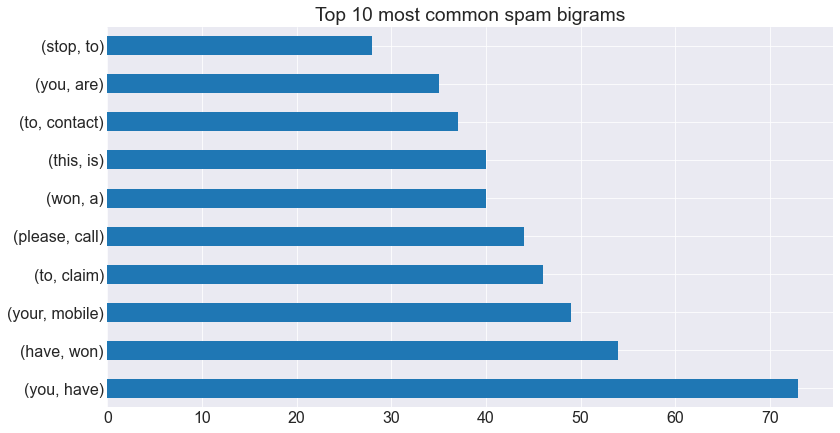

In [22]:
pd.Series(nltk.bigrams(spam_words.split())).value_counts().head(10).plot.barh()
plt.title('Top 10 most common spam bigrams')

## Word Cloud

`python -m pip install --upgrade wordcloud`

documentation: https://amueller.github.io/word_cloud/

`conda install -c conda-forge wordcloud`


(-0.5, 799.5, 599.5, -0.5)

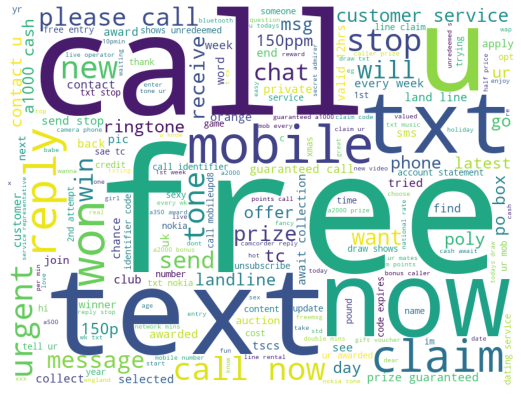

In [23]:
from wordcloud import WordCloud
img = WordCloud(background_color='white', width=800, height=600).generate(spam_words)
plt.imshow(img)
plt.axis('off')

Wordcloud used its own stopword filter by default

## Other Common Features

Any NLP dataset will have domain specific features, for example: number of retweets, number of @mentions, number of upvotes, or mean time to respond to a support chat. In addition to these domain specific features, some common measures for a document are:

- character count
- word count
- sentence count
- stopword count
- unique word count
- punctuation count
- average word length
- average words per sentence
- word to stopword ratio

Create one or more of the above features and visualize it.

In [24]:
# add two new columns 'message_length' and 'word_count'

df['message_length'] = df.text.apply(len)

df['word_count'] = df.text.apply(clean).apply(str.split).apply(len)

df.head()

,label,text,message_length,word_count
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",111,20
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,155,28
3,ham,U dun say so early hor... U c already then say...,49,11
4,ham,"Nah I don't think he goes to usf, he lives around here though",61,13


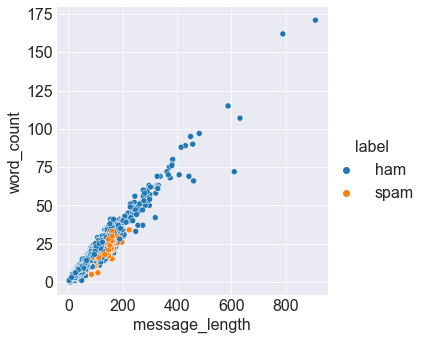

In [25]:
sns.relplot(data = df, x = 'message_length', y = 'word_count', hue = 'label');

In [26]:
df.groupby('label').message_length.agg(['mean', 'median', 'std'])

,mean,median,std
label,,,
ham,71.023627,52.0,58.016023
spam,138.866131,149.0,29.183082


## Sentiment

A number indicating whether the document is positive or negative.

- knowledge-based + statistical approach
- relies on human-labelled data
    - combination of qualitative and quantitative methods
    - then empirically validate
- different models for diff domains (e.g. social media vs news)
- for social media
    - Afinn ([github](https://github.com/fnielsen/afinn) + [whitepaper](http://www2.imm.dtu.dk/pubdb/edoc/imm6006.pdf))
    - Vader ([github](https://github.com/cjhutto/vaderSentiment) + [whitepaper](http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf)) `nltk.sentiment.vader.SentimentIntensityAnalyzer`. Pre-trained sentiment analyzer (**V**alence **A**ware **D**ictionary and s**E**ntiment **R**easoner).)


From your terminal:
`python -c 'import nltk;nltk.download("vader_lexicon")'`

In [27]:
import nltk.sentiment

sia = nltk.sentiment.SentimentIntensityAnalyzer()
sia.polarity_scores('He is really good')

{'neg': 0.0, 'neu': 0.484, 'pos': 0.516, 'compound': 0.4927}

In [28]:
sia.polarity_scores('He is really good!!!')

{'neg': 0.0, 'neu': 0.424, 'pos': 0.576, 'compound': 0.6211}

In [29]:
sia.polarity_scores('He is REALLY good')

{'neg': 0.0, 'neu': 0.433, 'pos': 0.567, 'compound': 0.6028}

In [30]:
sia.polarity_scores('He is very good!!!')

{'neg': 0.0, 'neu': 0.424, 'pos': 0.576, 'compound': 0.6211}

In [31]:
sia.polarity_scores('The food is good but service is slow')

{'neg': 0.0, 'neu': 0.782, 'pos': 0.218, 'compound': 0.2382}

In [32]:
sia.polarity_scores('He is good :-)')

{'neg': 0.0, 'neu': 0.278, 'pos': 0.722, 'compound': 0.6369}

In [33]:
sia.polarity_scores('The food SUX')

{'neg': 0.618, 'neu': 0.382, 'pos': 0.0, 'compound': -0.4995}

In [34]:
sia.polarity_scores('The food SUX ass')

{'neg': 0.771, 'neu': 0.229, 'pos': 0.0, 'compound': -0.7739}

In [35]:
sia.polarity_scores('The food SUX')

{'neg': 0.618, 'neu': 0.382, 'pos': 0.0, 'compound': -0.4995}

In [36]:
sia.polarity_scores('The food is shit')

{'neg': 0.545, 'neu': 0.455, 'pos': 0.0, 'compound': -0.5574}

In [37]:
sia.polarity_scores('The food is the shit')

{'neg': 0.0, 'neu': 0.5, 'pos': 0.5, 'compound': 0.6124}

In [38]:
sia.polarity_scores('The food is ass')

{'neg': 0.538, 'neu': 0.462, 'pos': 0.0, 'compound': -0.5423}

In [42]:
sia.polarity_scores('The food is bad ass')

{'neg': 0.0, 'neu': 0.375, 'pos': 0.625, 'compound': 0.6124}

In [43]:
sia.polarity_scores('The food is fucking bad ass')

{'neg': 0.0, 'neu': 0.444, 'pos': 0.556, 'compound': 0.6124}

In [44]:
sia.polarity_scores('The food is bad fucking ass')

{'neg': 0.646, 'neu': 0.354, 'pos': 0.0, 'compound': -0.807}

In [50]:
sia.polarity_scores('I fucking love this shit')

{'neg': 0.414, 'neu': 0.181, 'pos': 0.406, 'compound': -0.0224}

In [51]:
sia.polarity_scores('I love this shit')

{'neg': 0.409, 'neu': 0.114, 'pos': 0.477, 'compound': 0.1531}

In [52]:
sia.polarity_scores('I love this fucking shit')

{'neg': 0.386, 'neu': 0.198, 'pos': 0.416, 'compound': 0.079}

Things that can influence Sentiment Score:
1. Punctuations. Can increase the intensity
2. Capitalization. Can increase the intensity
3. Degree modifiers
4. Conjunctions

It can handle Emojis and slangs

Apply this to the text message data

In [45]:
df['sentiment'] = df.text.apply(lambda doc: sia.polarity_scores(doc)['compound'])
df

,label,text,message_length,word_count,sentiment
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",111,20,0.6249
1,ham,Ok lar... Joking wif u oni...,29,6,0.4767
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,155,28,0.7964
3,ham,U dun say so early hor... U c already then say...,49,11,0.0000
4,ham,"Nah I don't think he goes to usf, he lives around here though",61,13,-0.1027
...,...,...,...,...,...
5567,spam,"This is the 2nd time we have tried 2 contact u. U have won the å£750 Pound prize. 2 claim is easy, call 087187272008 NOW1! Only 10p per minute. BT-national-rate.",161,30,0.8805
5568,ham,Will Ì_ b going to esplanade fr home?,37,8,0.0000
5569,ham,"Pity, * was in mood for that. So...any other suggestions?",57,9,-0.2960
5570,ham,The guy did some bitching but I acted like i'd be interested in buying something else next week and he gave it to us for free,125,26,0.8934


In [46]:
# is the mean and median values of sentiment score different for ham vs spam?
df.groupby('label').sentiment.agg(['mean','median'])

,mean,median
label,,
ham,0.152218,0.0000
spam,0.436018,0.6107


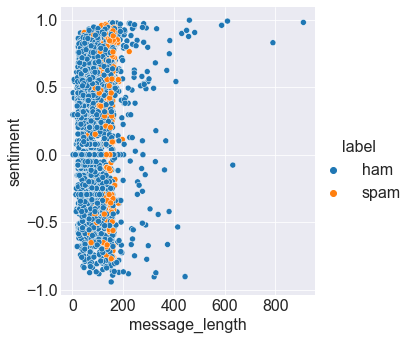

In [47]:
#plot message_length vs sentiment and hue by label
sns.relplot(data = df, x = 'message_length', y = 'sentiment', hue = 'label')

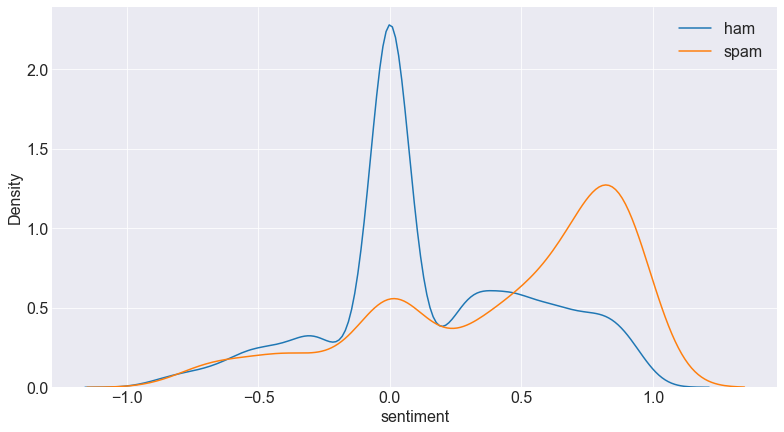

In [48]:
# is the distribution for sentiment different for ham vs spam
sns.kdeplot(df[df.label == 'ham'].sentiment, label = 'ham')
sns.kdeplot(df[df.label == 'spam'].sentiment, label = 'spam');
plt.legend(['ham', 'spam'])

/opt/homebrew/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


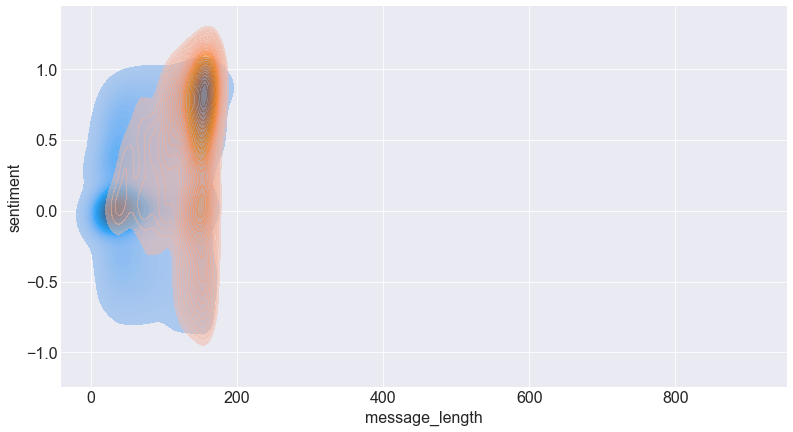

In [49]:
# Bivariate KDE plot for message_length vs sentiment score 
sns.kdeplot(df[df.label == 'ham'].message_length,df[df.label == 'ham'].sentiment, levels = 30, shade = True );
sns.kdeplot(df[df.label == 'spam'].message_length,df[df.label == 'spam'].sentiment, levels = 30, shade = True, alpha = 0.5 );

## More Resources

- [kaggle wikipedia movie plots](https://www.kaggle.com/jrobischon/wikipedia-movie-plots)
    - Suggestion: narrow to top n genres that aren't unknown
- [wikitable extractor](https://wikitable2csv.ggor.de/) (Try with, e.g. [helicopter prison escapes](https://en.wikipedia.org/wiki/List_of_helicopter_prison_escapes))
- [Textblob library](https://textblob.readthedocs.io/en/dev/)